# Comparison of an SMPI trace with optimization levels 1 and 3

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
import json
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    df['duration'] = df['end'] - df['start']
    return df, df_links

def get_optimization(filename):
    history = json.loads(zipfile.ZipFile(filename).read('history.json'))
    make_cmd = [cmd for cmd in history if 'SMPI_OPTIMIZATION' in cmd['command']][0]['command']
    opt = re.findall('SMPI_OPTIMIZATION[^\s-]*', make_cmd)[0]
    if opt == 'SMPI_OPTIMIZATION':
        return 4
    else:
        assert opt[-2] == '='
        return int(opt[-1])

files = [
    '../smpi_hpl/grenoble_2018-12-21_1830848.zip',
    '../smpi_hpl/grenoble_2018-12-21_1830851.zip',
]

traces = []
links = []
for f in files:
    new_trace, new_link = read_archive(f, 'simgrid')
    opt = get_optimization(f)
    new_trace['optimization'] = opt
    new_link['optimization'] = opt
    traces.append(new_trace)
    links.append(new_link)

traces = pandas.concat(traces)
links = pandas.concat(links)

print(traces['optimization'].unique())

traces.head()

# Mode: simgrid
	BLAS trace: 596234 lines
	MPI  trace: 1134436 lines
Removed 16 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 695276 lines
	MPI  trace: 1119105 lines
Removed 16 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
[1 3]


,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1,duration,optimization
0,7.217775,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,7.21775,simgrid,1,0.000025,1
1,7.218186,dgemm,2.0,BLAS,25038.0,-1,2.0,0,7.21784,simgrid,1,0.000346,1
2,7.218411,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,7.21839,simgrid,1,0.000021,1
3,7.218765,dgemm,2.0,BLAS,25036.0,-1,0.0,0,7.21842,simgrid,1,0.000345,1
4,7.218791,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,7.21877,simgrid,1,0.000021,1


In [2]:
links.head()

,type,level,container,start,end,duration,commType,src,dst,msg_size,optimization
0,Link,0,MPI_LINK,0.000004,0.000005,0.000001,PTP,7,6,4,1
1,Link,0,MPI_LINK,0.000004,0.000006,0.000002,PTP,3,2,4,1
2,Link,0,MPI_LINK,0.000004,0.000006,0.000002,PTP,5,4,4,1
3,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,6,4,4,1
4,Link,0,MPI_LINK,0.000006,0.000079,0.000073,PTP,1,0,4,1


## HPL result

In [3]:
res = read_csv(files[0], 'results.csv')
print('%s Gflops' % res['gflops'].max())
print('%s seconds' % res['time'].max())
res

1927.0 Gflops
44.69 seconds


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,dtrsm_intercept,time,gflops,simulation_time,application_time,usr_time,sys_time,major_page_fault,minor_page_fault,cpu_utilization
0,50000,128,2,4,1,2,2,1,0,8,...,0.00004,43.24,1927.0,322.342,209.786,1098.24,3182.24,0,9350032,13.27
1,50000,128,2,4,1,2,2,1,0,8,...,0.00004,44.58,1869.0,335.384,217.051,1157.68,3356.04,0,9066454,13.45
2,50000,128,2,4,1,2,2,1,0,8,...,0.00004,44.69,1865.0,327.863,218.332,1112.77,3283.81,0,9121573,13.40


In [4]:
res = read_csv(files[1], 'results.csv')
print('%s Gflops' % res['gflops'].max())
print('%s seconds' % res['time'].max())
res

2481.0 Gflops
33.6 seconds


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,dtrsm_intercept,time,gflops,simulation_time,application_time,usr_time,sys_time,major_page_fault,minor_page_fault,cpu_utilization
0,50000,128,2,4,1,2,2,1,0,8,...,0.00004,33.59,2481.0,33.3242,4.28134,27.07,10.12,0,1466024,1.11
1,50000,128,2,4,1,2,2,1,0,8,...,0.00004,33.60,2480.0,33.3101,4.32296,26.94,10.36,0,1538591,1.11
2,50000,128,2,4,1,2,2,1,0,8,...,0.00004,33.60,2480.0,33.0687,4.34888,27.06,10.17,0,1469450,1.12


## Checking the parameters

In [5]:
params = pandas.concat([read_csv(f, 'exp_smpi.csv') for f in files])
params = params.drop_duplicates()
assert len(params) == 1
params

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,50000,128,2,4,1,2,2,1,0,8,1,32,2.548998e-12,0.000099,4.524788e-12,0.00004


In [6]:
platforms = set([zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in files])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

### Removing the initialization and the finalization in the traces

In [7]:
for opt in sorted(traces['optimization'].unique()):
    for kind in sorted(traces['kind'].unique()):
        df = traces[(traces['optimization'] == opt) & (traces['kind'] == kind)]
        print('optim %d, kind %s' % (opt, kind), df.start.min(), df.end.max())
    print()

optim 1, kind BLAS 7.21775 50.369977000000006
optim 1, kind MPI 0.0 60.485409999999995

optim 3, kind BLAS 0.030048000000000002 33.614077
optim 3, kind MPI 0.0 33.617737



In [8]:
def crop(df, links, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2 * len(df['rank'].unique())
    start = func_calls['start'].min()
    end = func_calls['end'].max()
    df = df[(df['start'] >= start) & (df['end'] <= end)].copy()
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    links = links[(links['start'] >= start) & (links['end'] <= end)].copy()
    links['start'] -= min_time
    links['end'] -= min_time
    return df, links

cropped_trace = []
cropped_link = []
for opt in traces['optimization'].unique():
    tmp_trace = traces[traces['optimization'] == opt]
    tmp_link = links[links['optimization'] == opt]
    tmp_trace, tmp_link = crop(tmp_trace, tmp_link, 'MPI_Bcast')
    cropped_trace.append(tmp_trace)
    cropped_link.append(tmp_link)

traces = pandas.concat(cropped_trace)
traces = traces[traces['function'] != 'MPI_Bcast']
links = pandas.concat(cropped_link)

In [9]:
for opt in sorted(traces['optimization'].unique()):
    for kind in sorted(traces['kind'].unique()):
        df = traces[(traces['optimization'] == opt) & (traces['kind'] == kind)]
        print('optim %d, kind %s' % (opt, kind), df.start.min(), df.end.max())
    print()

optim 1, kind BLAS 0.034719999999999196 43.186947
optim 1, kind MPI 6.999999999202089e-06 43.24229

optim 3, kind BLAS 0.0003040000000000022 33.583914
optim 3, kind MPI 3.0000000000030003e-06 33.586952999999994



### Zooming on the trace 

In [10]:
def plot(df, wrap=['optimization', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

def plot_bounded(df, start, end, ranks, wrap=['optimization', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

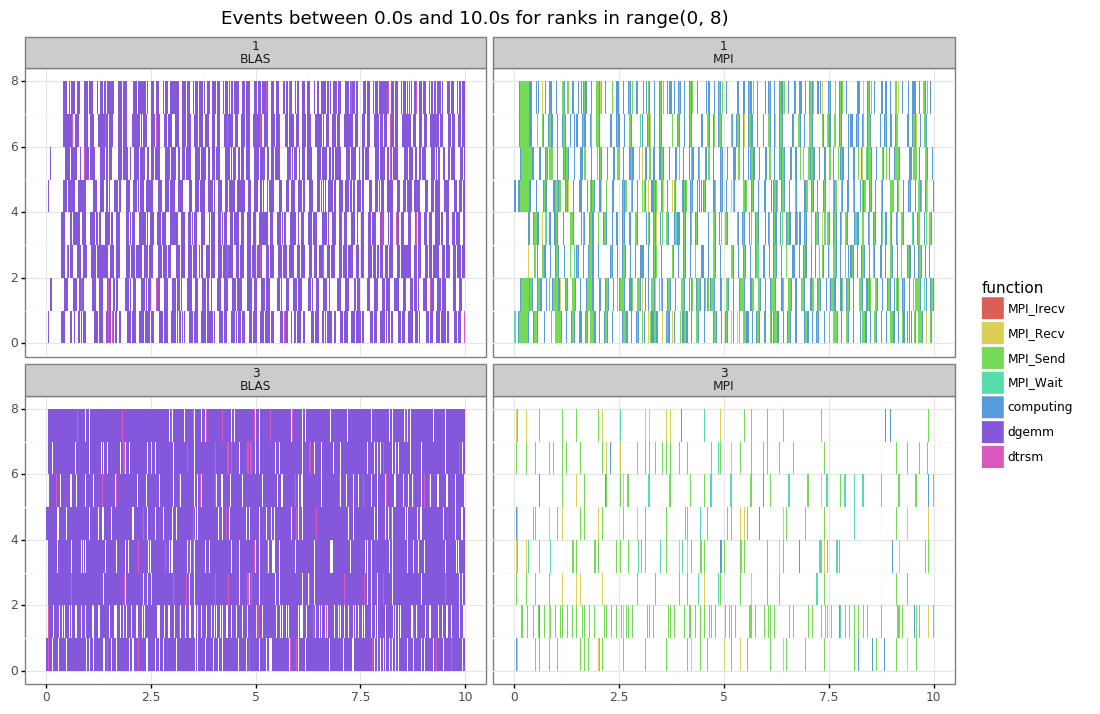

<ggplot: (-9223363280380739952)>

In [11]:
plot_bounded(traces, 0, 10, range(8))

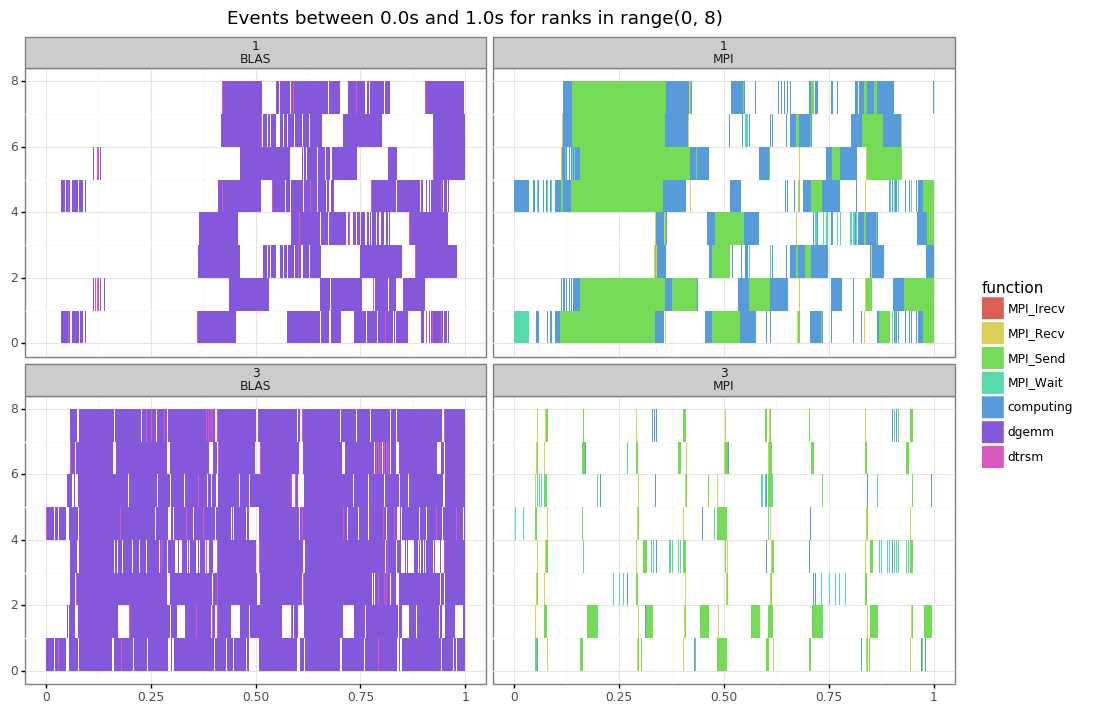

<ggplot: (8756387329996)>

In [12]:
plot_bounded(traces, 0, 1, range(8))

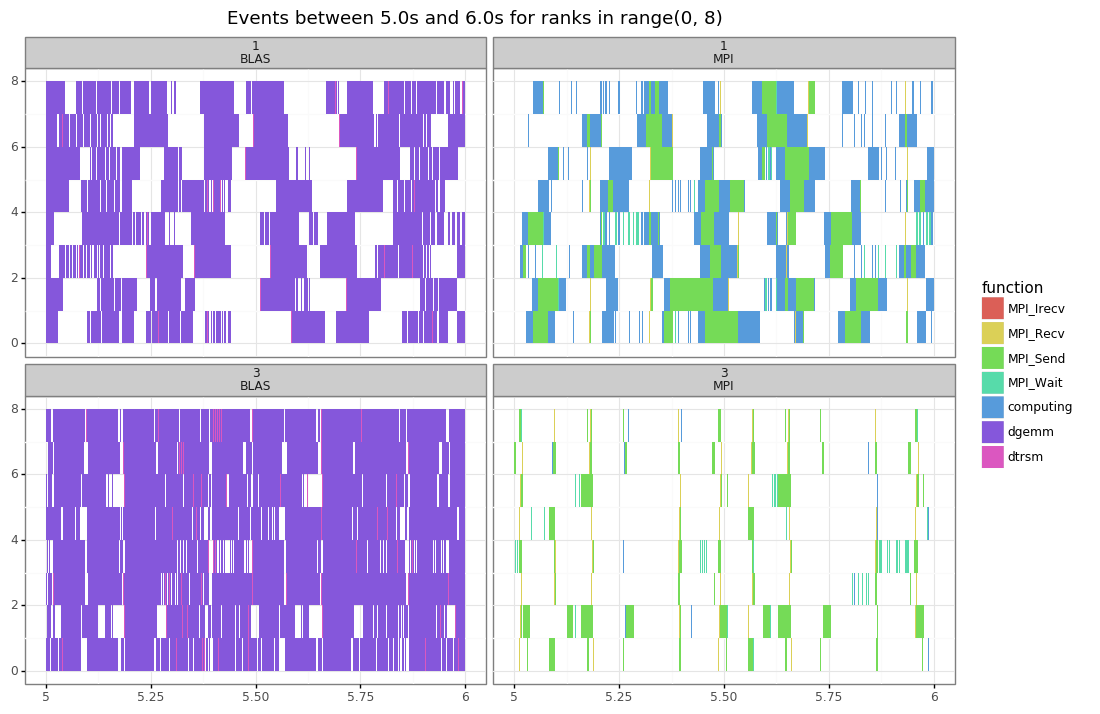

<ggplot: (8756474015601)>

In [13]:
plot_bounded(traces, 5, 6, range(8))

## Plotting the total time spent in each function

In [14]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'optimization', 'start', 'end', 'duration']].copy()
    df = df.groupby(['rank', 'optimization']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='factor(optimization)')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    optimizations = list(df['optimization'].unique())
    if len(optimizations) != 2:
        return
    df1 = df[df['optimization'] == optimizations[0]]
    df2 = df[df['optimization'] == optimizations[1]]
    df = df1.set_index('rank').join(df2.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

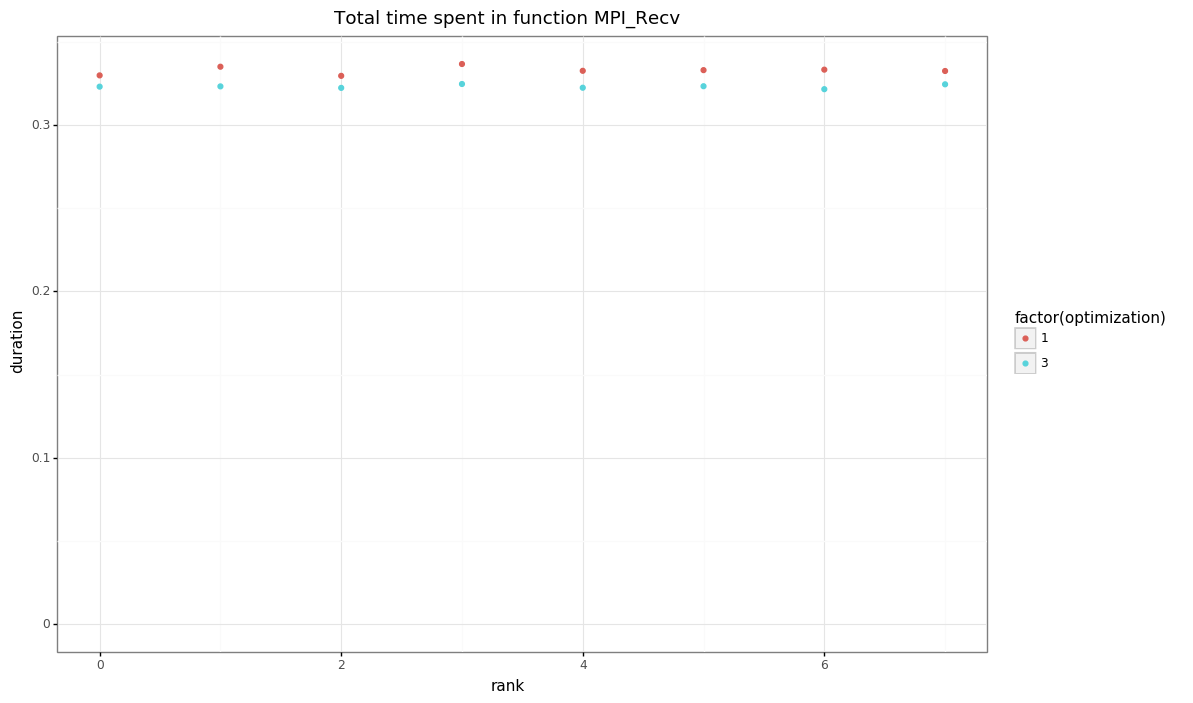

<ggplot: (-9223363280372656089)>


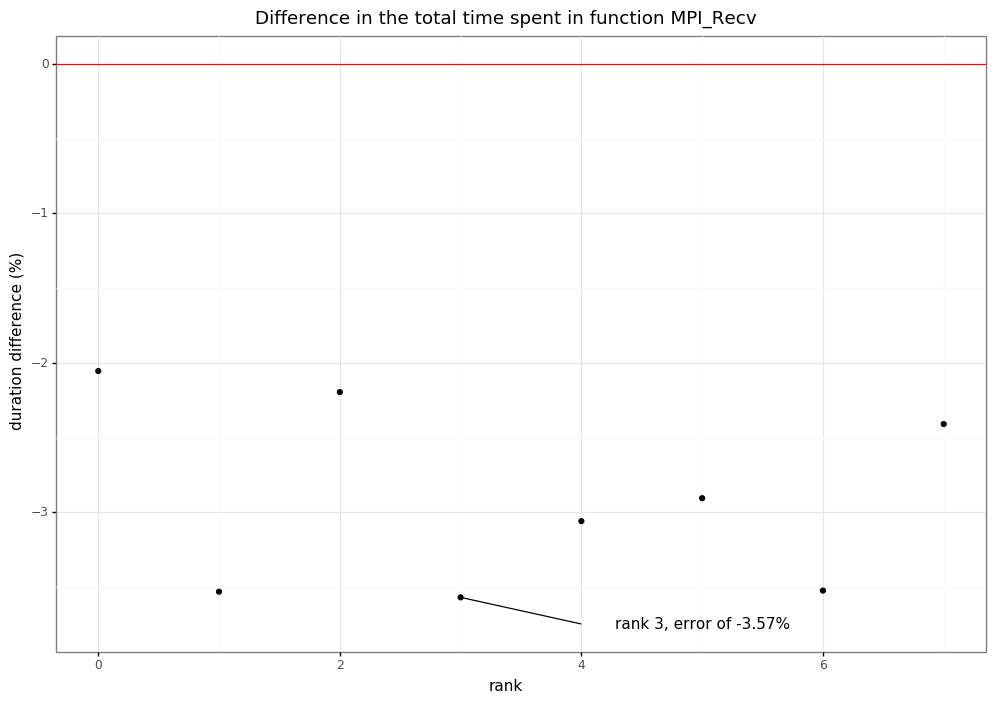

<ggplot: (8756365819761)>


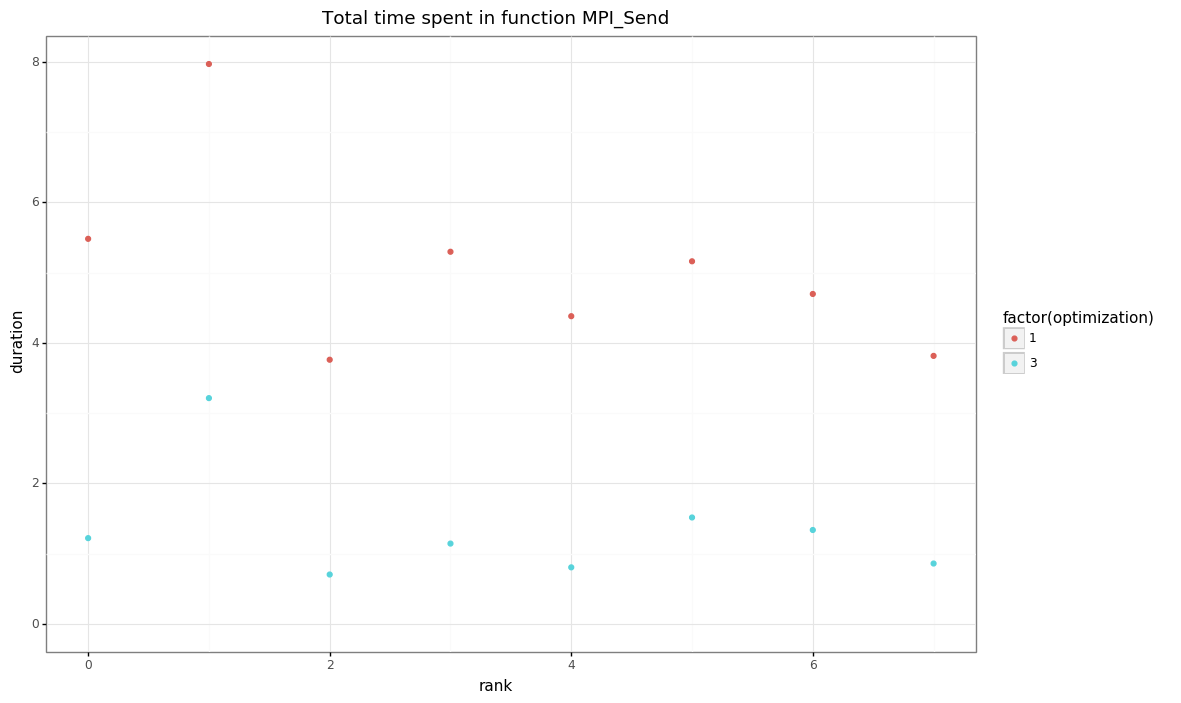

<ggplot: (8756365815830)>


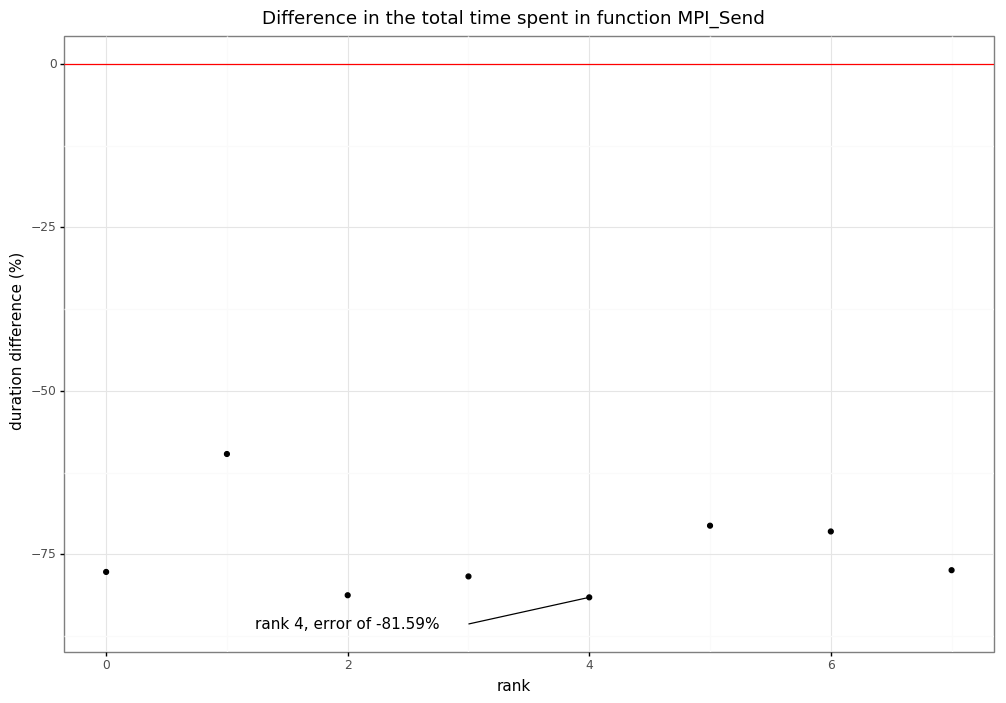

<ggplot: (-9223363280405566141)>


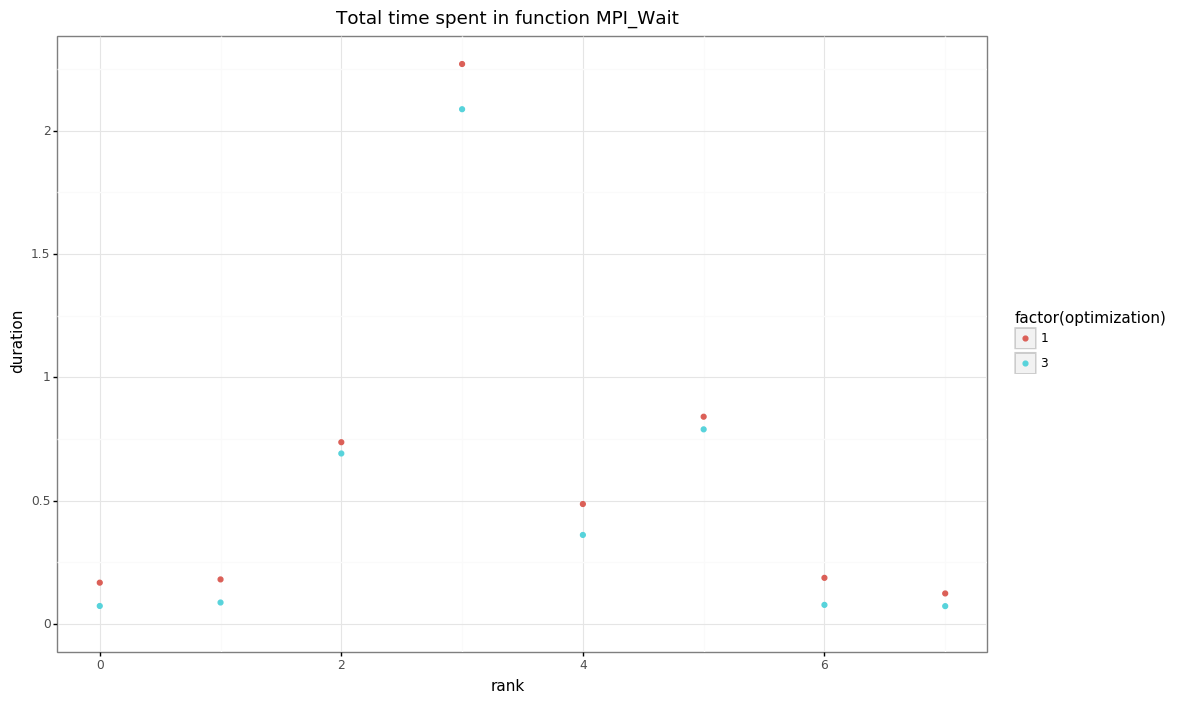

<ggplot: (-9223363280488959558)>


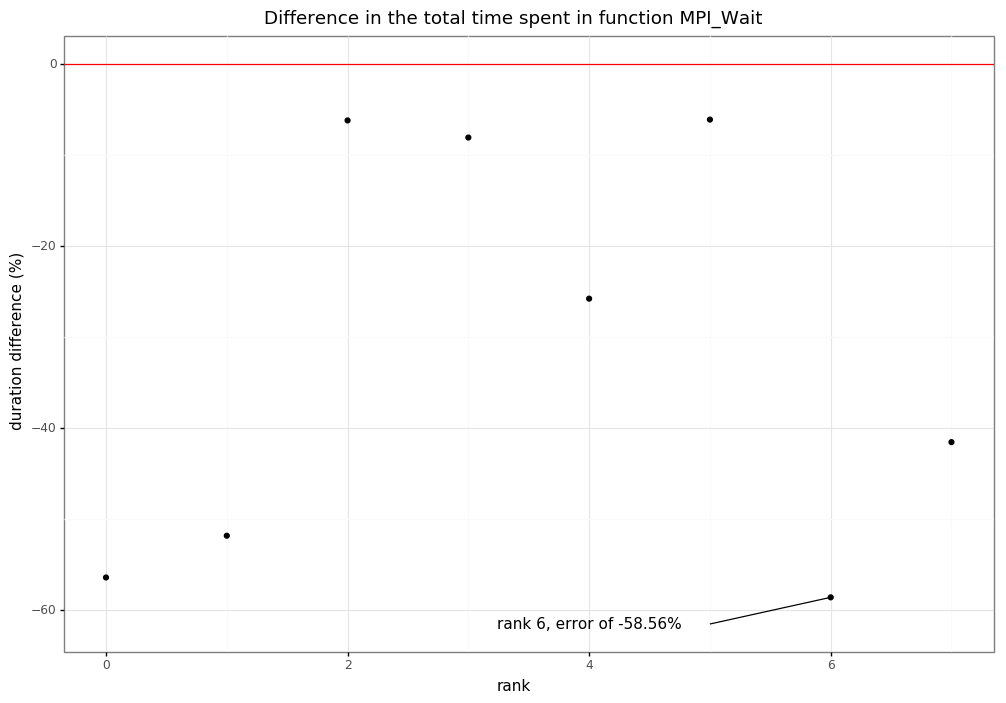

<ggplot: (8756449170636)>


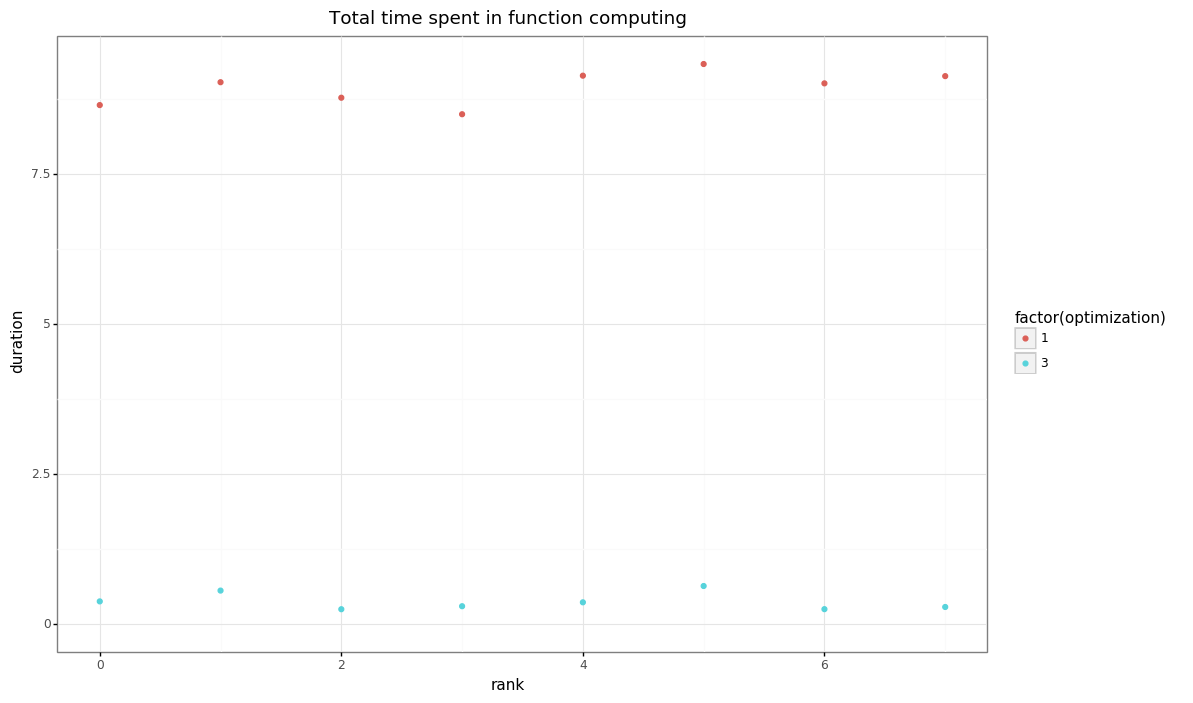

<ggplot: (-9223363280405543378)>


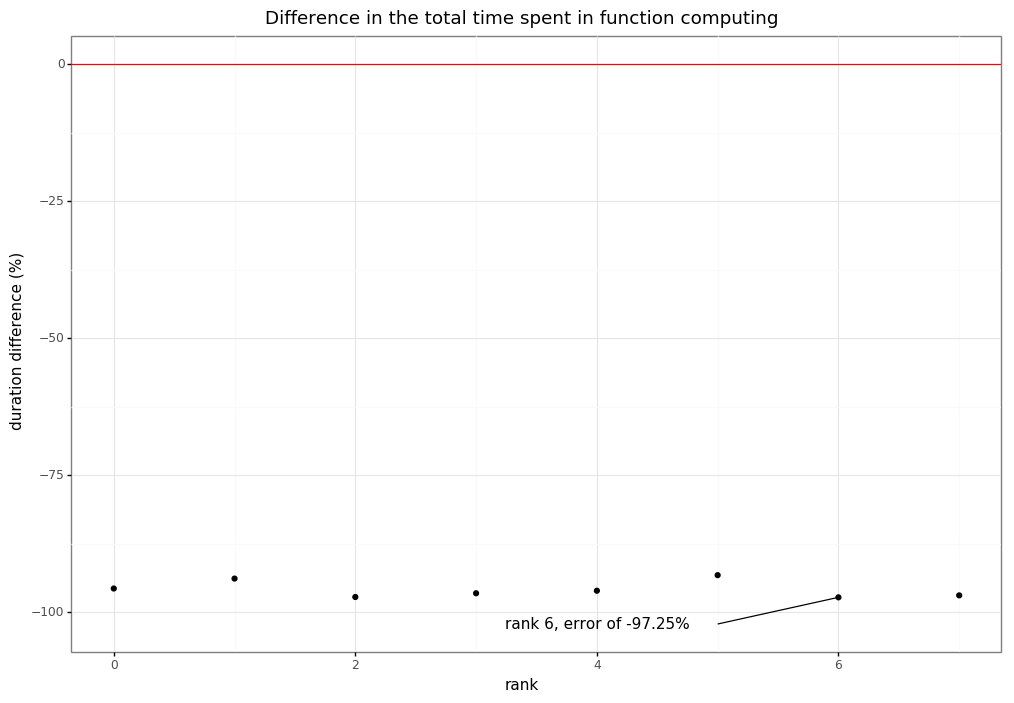

<ggplot: (-9223363280468352610)>


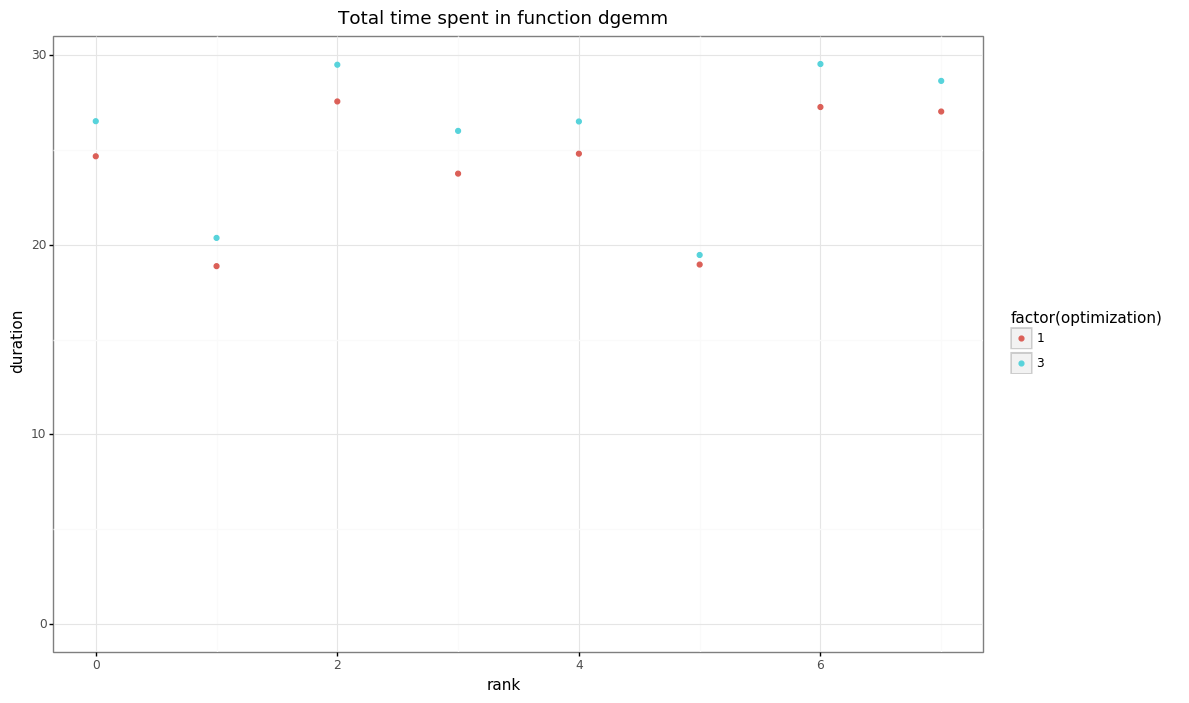

<ggplot: (-9223363280466905084)>


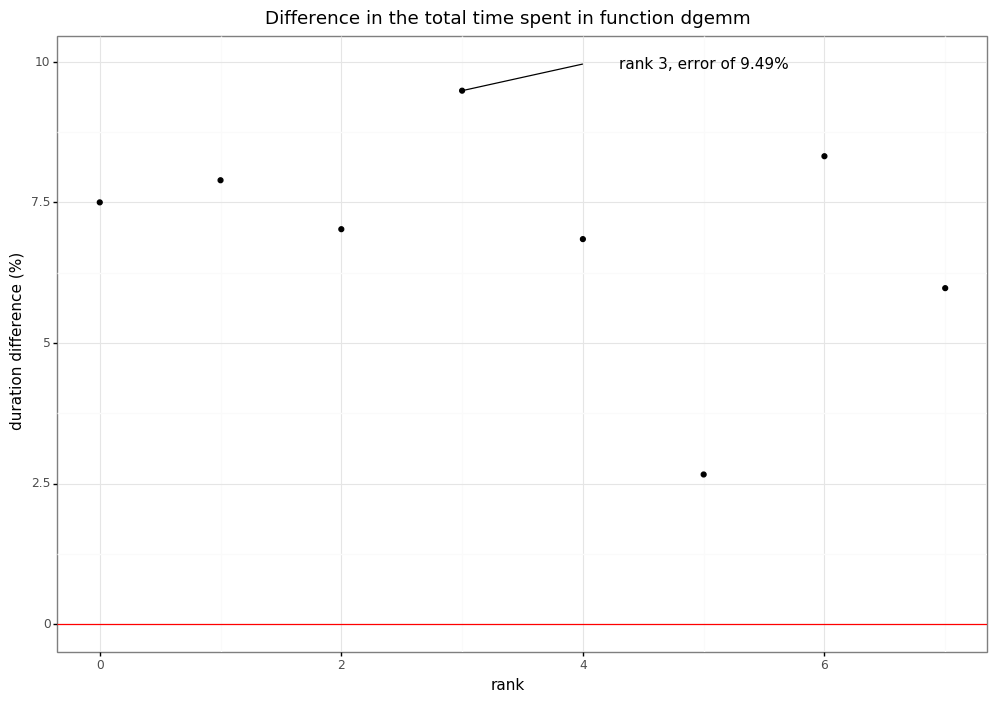

<ggplot: (8756387870735)>


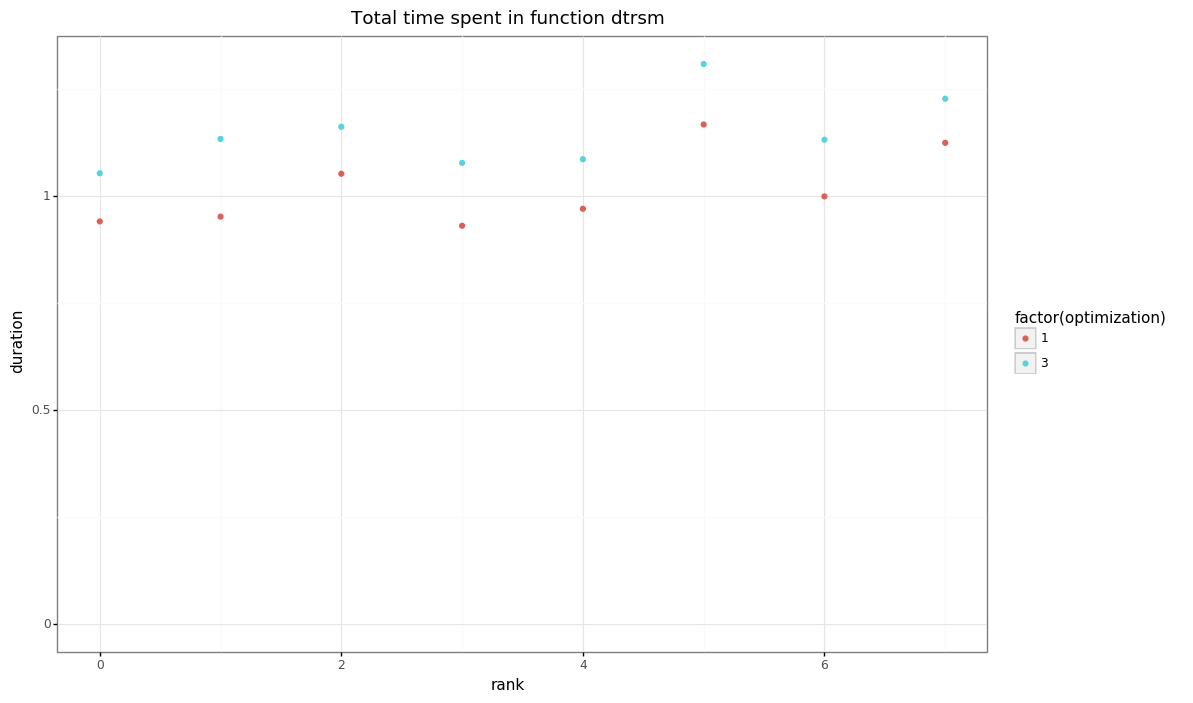

<ggplot: (8756386426639)>


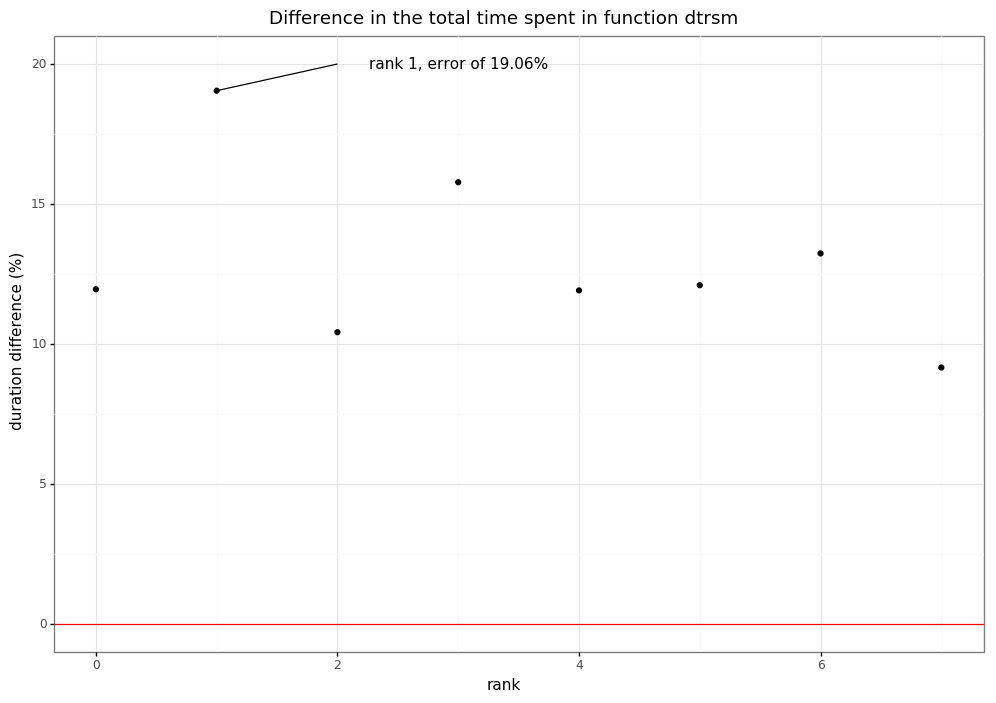

<ggplot: (8756387870924)>


In [15]:
for func in sorted(set(traces.function.unique()) - {'MPI_Bcast', 'MPI_Irecv'}):
    plot_total_duration(traces, func)

## Counting the number of events

In [16]:
traces[['function', 'optimization', 'rank']].groupby(['function', 'optimization']).count()

rank
function  optimization        
MPI_Irecv 1             103882
          3             103882
MPI_Recv  1               3518
          3               3517
MPI_Send  1             107400
          3             107399
MPI_Wait  1             103882
          3             103882
computing 1             815097
          3             800060
dgemm     1             298117
          3             347636
dtrsm     1             298117
          3             347636

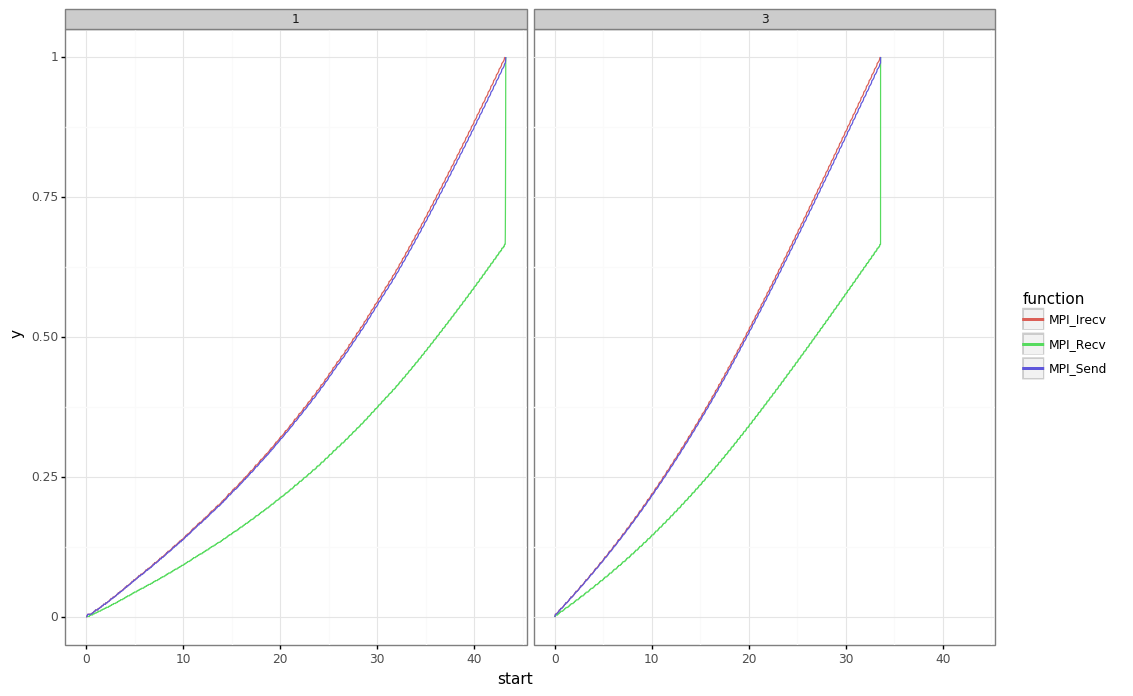

<ggplot: (8756386294655)>

In [17]:
ggplot(traces[traces.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('optimization') + theme_bw()

## Comparing the communications

In [18]:
traces[traces['function'].isin(['MPI_Send', 'MPI_Recv', 'MPI_Irecv'])].groupby(['function', 'optimization']).sum()[['msg_size', 'duration']]

msg_size   duration
function  optimization                        
MPI_Irecv 1             15117079816   0.000000
          3             15098795160   0.000000
MPI_Recv  1             30234276180   2.662611
          3             30234276176   2.585149
MPI_Send  1             45351355996  40.556704
          3             45333071336  10.805152

In [19]:
traces[traces['function'].isin(['MPI_Send', 'MPI_Recv', 'MPI_Irecv'])].groupby(['function', 'rank', 'optimization']).sum()[['msg_size', 'duration']]

msg_size  duration
function  rank optimization                      
MPI_Irecv 0    1             1881623584  0.000000
               3             1883750856  0.000000
          1    1             1900856720  0.000000
               3             1903033528  0.000000
          2    1             1886700272  0.000000
               3             1888857872  0.000000
          3    1             1881537208  0.000000
               3             1883664416  0.000000
          4    1             1895193232  0.000000
               3             1888463208  0.000000
          5    1             1895144152  0.000000
               3             1888414608  0.000000
          6    1             1900204880  0.000000
               3             1893460040  0.000000
          7    1             1875819768  0.000000
               3             1869150632  0.000000
MPI_Recv  0    1             3775229864  0.329855
               3             3775229864  0.323079
          1    1             3775230888  0.335072
               3             3775230888  0.323240
          2    1             3788105004  0.329580
               3             3788105000  0.322345
          3    1             3788156848  0.336690
               3             3788156848  0.324674
          4    1             3764023208  0.332607
               3             3764023208  0.322433
          5    1             3776868264  0.333008
               3             3776868264  0.323333
          6    1             3776948776  0.333302
               3             3776948776  0.321558
          7    1             3789713328  0.332497
               3             3789713328  0.324487
MPI_Send  0    1             5683351104  5.480408
               3             5676621080  1.221906
          1    1             5683250176  7.967727
               3             5676520632  3.214042
          2    1             5675487876  3.760357
               3             5668743032  0.704263
          3    1             5650996760  5.296667
               3             5644327624  1.144574
          4    1             5684181968  4.379643
               3             5686309240  0.806195
          5    1             5664960184  5.160806
               3             5667136992  1.515769
          6    1             5676334368  4.696006
               3             5678491968  1.337697
          7    1             5632793560  3.815090
               3             5634920768  0.860706

In [20]:
def compute_cumsum(df, column, functions):
    dataframes = []
    for opt in df['optimization'].unique():
        for function in functions:
            cols = ['start', 'end', 'function', 'optimization'] + [column]
            tmp = df[(df['optimization'] == opt) & (df['function'] == function)][cols].copy()
            tmp = tmp.sort_values(by=['start'])
            tmp['cumsum'] = tmp[column].cumsum()
            dataframes.append(tmp)
    return pandas.concat(dataframes)

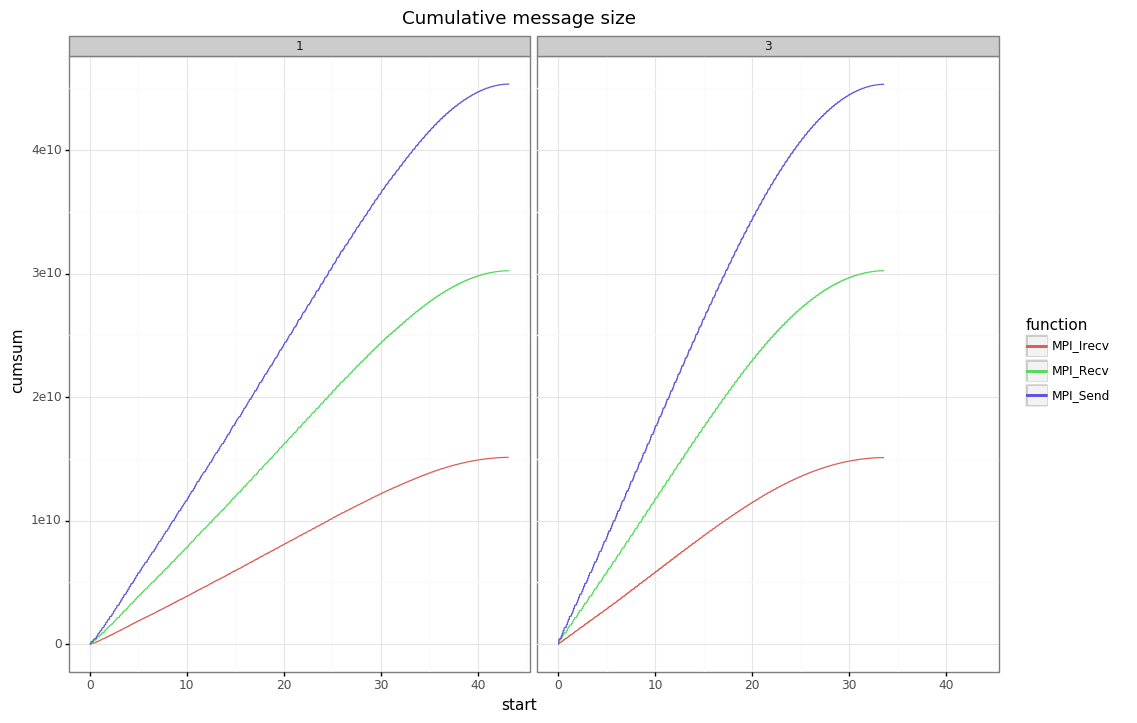

<ggplot: (-9223363280468417718)>

In [21]:
plot = ggplot(compute_cumsum(traces, 'msg_size', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('optimization') + ggtitle('Cumulative message size')

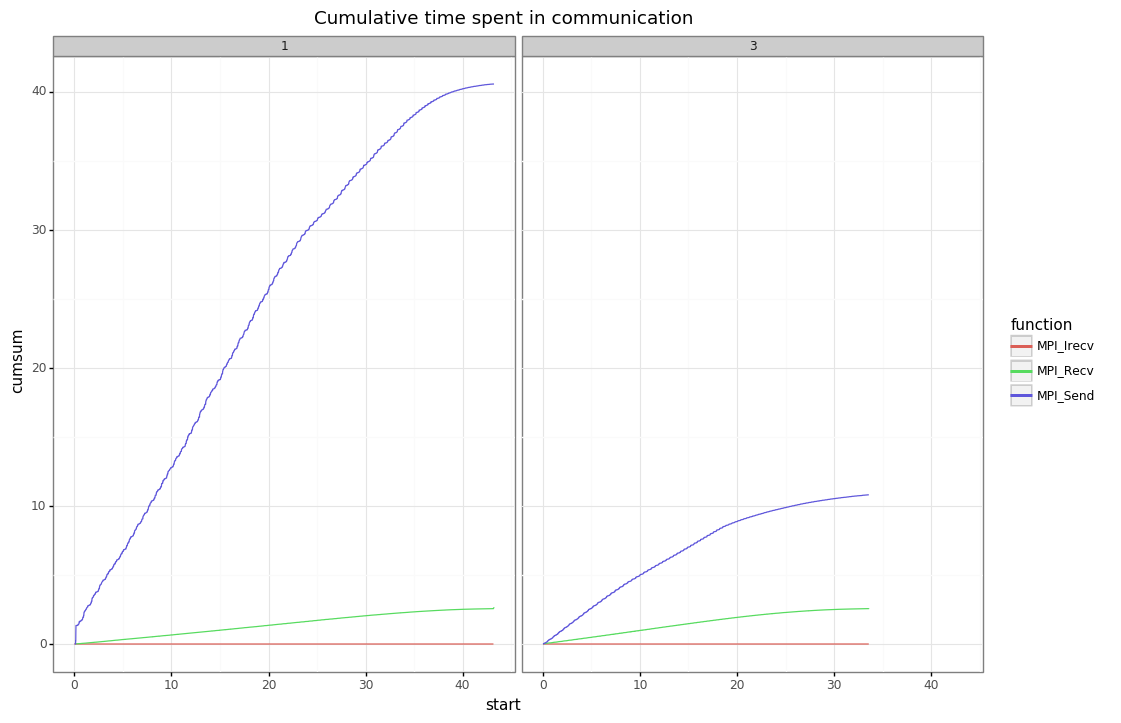

<ggplot: (-9223363280489292393)>

In [22]:
plot = ggplot(compute_cumsum(traces, 'duration', ['MPI_Send', 'MPI_Recv', 'MPI_Irecv']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('optimization') + ggtitle('Cumulative time spent in communication')

## Comparing the computations

In [23]:
tmp = traces[traces['kind'] == 'BLAS'].copy().reset_index(drop=True)
tmp['size_product'] = -1
tmp.loc[tmp['function'] == 'dgemm', 'size_product'] = tmp['m'] * tmp['n'] * tmp['k']
tmp.loc[tmp['function'] == 'dtrsm', 'size_product'] = tmp['m'] * tmp['n']**2

In [24]:
tmp.groupby(['function', 'optimization']).sum()[['size_product', 'duration']]

size_product    duration
function optimization                          
dgemm    1             4.158680e+13  192.900256
         3             4.158680e+13  206.517534
dtrsm    1             3.194668e+11    8.140505
         3             3.194668e+11    9.183969

In [25]:
tmp.groupby(['function', 'rank', 'optimization']).sum()[['size_product', 'duration']]

size_product   duration
function rank optimization                         
dgemm    0    1             5.198147e+12  24.666700
              3             5.198147e+12  26.517178
         1    1             5.218160e+12  18.872084
              3             5.218160e+12  20.362112
         2    1             5.208855e+12  27.558867
              3             5.208855e+12  29.494755
         3    1             5.178136e+12  23.751786
              3             5.178136e+12  26.005610
         4    1             5.193150e+12  24.803361
              3             5.193150e+12  26.501937
         5    1             5.213241e+12  18.957047
              3             5.213241e+12  19.461403
         6    1             5.203845e+12  27.263448
              3             5.203845e+12  29.532548
         7    1             5.173267e+12  27.026963
              3             5.173267e+12  28.641991
dtrsm    0    1             3.990530e+10   0.941162
              3             3.990530e+10   1.053750
         1    1             4.011082e+10   0.952427
              3             4.011082e+10   1.133951
         2    1             4.001576e+10   1.052694
              3             4.001576e+10   1.162468
         3    1             3.970153e+10   0.931052
              3             3.970153e+10   1.078036
         4    1             3.990530e+10   0.970815
              3             3.990530e+10   1.086539
         5    1             4.011082e+10   1.167771
              3             4.011082e+10   1.309144
         6    1             4.001576e+10   0.999651
              3             4.001576e+10   1.132031
         7    1             3.970153e+10   1.124933
              3             3.970153e+10   1.228050

In [26]:
print(len(tmp))
tmp = tmp[tmp['size_product'] > 0]
print(len(tmp))

1291506
443560


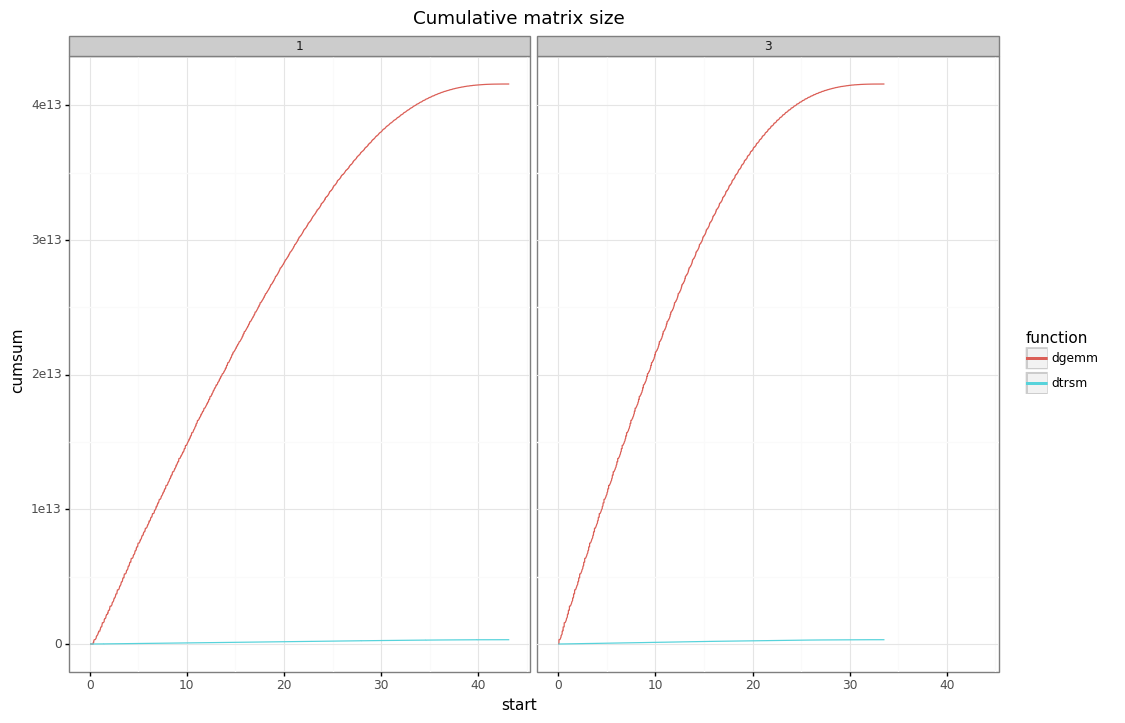

<ggplot: (-9223363280466907616)>

In [27]:
plot = ggplot(compute_cumsum(tmp, 'size_product', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('optimization') + ggtitle('Cumulative matrix size')

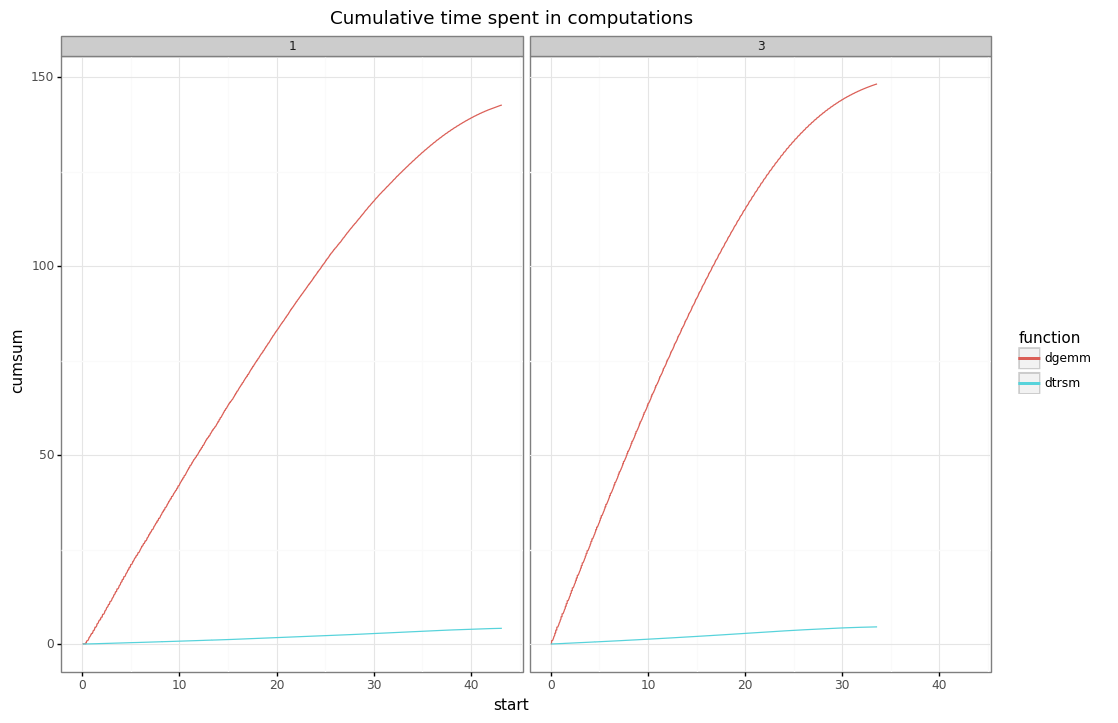

<ggplot: (8756449241818)>

In [28]:
plot = ggplot(compute_cumsum(tmp, 'duration', ['dgemm', 'dtrsm']), aes(x='start', y='cumsum', color='function', group='function'))
plot + geom_line() + theme_bw() + facet_wrap('optimization') + ggtitle('Cumulative time spent in computations')